In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import re

import folium

from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputRegressor

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RANSACRegressor

from sklearn.metrics import r2_score,mean_squared_error

In [13]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

# Data Load

In [3]:
df = pd.read_csv('../data/train.csv')
df.columns = [label.lower() for label in df.columns]
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


## Data Dimension

In [4]:
print('Number of rows: {}\nNumber of columns: {}'.format(df.shape[0], df.shape[1]))

Number of rows: 1710670
Number of columns: 9


## Nan Values

In [5]:
100*df.isna().sum()/df.shape[0]

trip_id          0.000000
call_type        0.000000
origin_call     78.676776
origin_stand    52.850111
taxi_id          0.000000
timestamp        0.000000
day_type         0.000000
missing_data     0.000000
polyline         0.000000
dtype: float64

## Data Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   trip_id       int64  
 1   call_type     object 
 2   origin_call   float64
 3   origin_stand  float64
 4   taxi_id       int64  
 5   timestamp     int64  
 6   day_type      object 
 7   missing_data  bool   
 8   polyline      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


# Data Filtering

In [7]:
# verify if we have None init lat/long
df['polyline'].str[:2].unique()

array(['[[', '[]'], dtype=object)

In [8]:
# verify if we have None last lat/long
df['polyline'].str[-2:].unique()

array([']]', '[]'], dtype=object)

In [9]:
print(df.shape)
df = df.loc[df['polyline'].str[:2] != '[]']
df = df.loc[df['polyline'].str[-2:] != '[]']
print(df.shape)

(1710670, 9)
(1704769, 9)


# Feature Engineering

In [10]:
# change space of origin_stand
df['int_origin_stand'] = 1
df.loc[df['origin_stand'].isna(),'int_origin_stand'] = 0

# change space of origin_call
df['int_origin_call'] = 1
df.loc[df['origin_call'].isna(),'int_origin_call'] = 0


# change space of missing_data
df['int_missing_data'] = 1
df.loc[(df['missing_data'] == False) | (df['missing_data'] == 'False'),'int_missing_data'] = 0

# # dummies for call_type
# df = pd.get_dummies(df,columns=['call_type'],prefix='ct', drop_first=False)

In [11]:
# change to UTC date format
df['date'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

# just keep YYYY-MM-DD
df['date2'] = pd.to_datetime(df['date'].astype(str).str[:10],format = '%Y-%m-%d')

In [12]:
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,int_origin_stand,int_origin_call,int_missing_data,date,date2
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",0,0,0,2013-07-01 00:00:58+00:00,2013-07-01
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,0,0,2013-07-01 00:08:23+00:00,2013-07-01
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",0,0,0,2013-07-01 00:02:31+00:00,2013-07-01
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",0,0,0,2013-07-01 00:00:54+00:00,2013-07-01
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",0,0,0,2013-07-01 00:04:51+00:00,2013-07-01


In [13]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [14]:
vetor_coord = df['polyline'].values
lat_init = []
lat_end = []
long_init = []
long_end = []

for i in vetor_coord:
    string_vetor = re.sub(r"[\[\]\|]", "", i)
    lat_init.append(string_vetor.split(',')[1])
    lat_end.append(string_vetor.split(',')[-1])
    long_init.append(string_vetor.split(',')[0])
    long_end.append(string_vetor.split(',')[-2])


df['lat_init'] = lat_init
df['long_init'] = long_init
df['lat_end'] = lat_end
df['long_end'] = long_end
for i in ['lat_init','lat_end','long_init','long_end']:
    df[i] = df[i].astype(float)



In [15]:
try:
    del lat_init
    del lat_end
    del long_init
    del long_end
    del vetor_coord
except:
    pass

In [16]:
df.head(3)

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,int_origin_stand,int_origin_call,int_missing_data,date,date2,year,month,lat_init,long_init,lat_end,long_end
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",0,0,0,2013-07-01 00:00:58+00:00,2013-07-01,2013,7,41.141412,-8.618643,41.154489,-8.630838
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,0,0,2013-07-01 00:08:23+00:00,2013-07-01,2013,7,41.159826,-8.639847,41.170671,-8.665740
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",0,0,0,2013-07-01 00:02:31+00:00,2013-07-01,2013,7,41.140359,-8.612964,41.140530,-8.615970


# EDA

In [17]:
df.head(3)

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,int_origin_stand,int_origin_call,int_missing_data,date,date2,year,month,lat_init,long_init,lat_end,long_end
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",0,0,0,2013-07-01 00:00:58+00:00,2013-07-01,2013,7,41.141412,-8.618643,41.154489,-8.630838
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,0,0,2013-07-01 00:08:23+00:00,2013-07-01,2013,7,41.159826,-8.639847,41.170671,-8.665740
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",0,0,0,2013-07-01 00:02:31+00:00,2013-07-01,2013,7,41.140359,-8.612964,41.140530,-8.615970


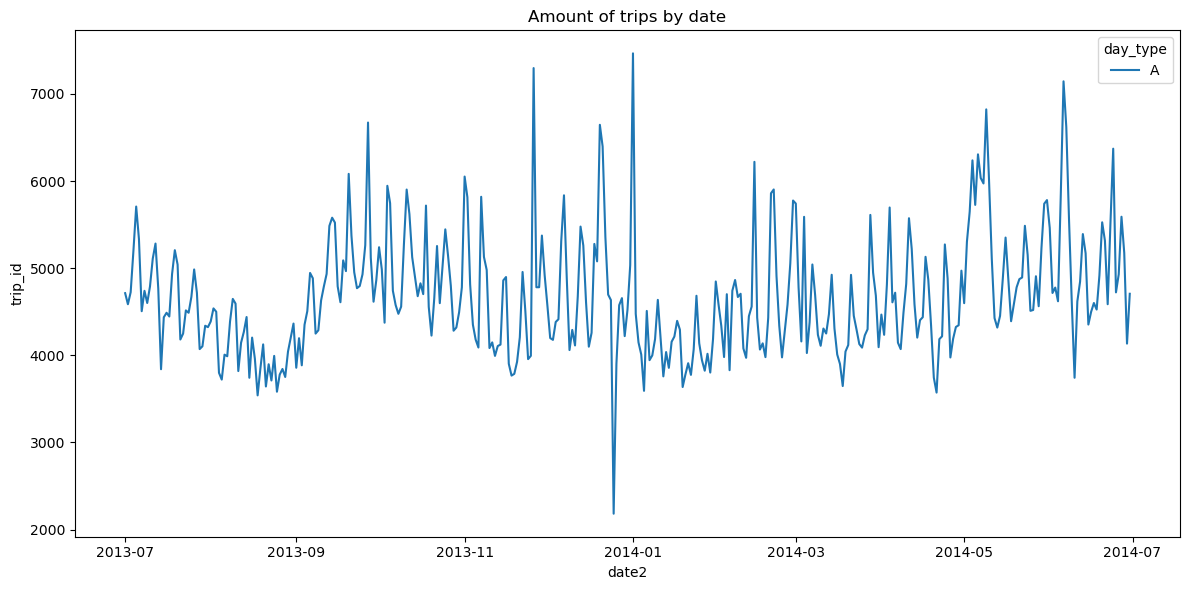

In [18]:
aux = df.groupby(['date2','day_type'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'day_type', ax = axes);
axes.set_title('Amount of trips by date')
plt.tight_layout();

We just have DAY_TYPE = 'A' (normal day) and basically all trips are concentrated between 4000 and 6000

In [19]:
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,int_origin_stand,int_origin_call,int_missing_data,date,date2,year,month,lat_init,long_init,lat_end,long_end
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",0,0,0,2013-07-01 00:00:58+00:00,2013-07-01,2013,7,41.141412,-8.618643,41.154489,-8.630838
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",1,0,0,2013-07-01 00:08:23+00:00,2013-07-01,2013,7,41.159826,-8.639847,41.170671,-8.665740
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",0,0,0,2013-07-01 00:02:31+00:00,2013-07-01,2013,7,41.140359,-8.612964,41.140530,-8.615970
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",0,0,0,2013-07-01 00:00:54+00:00,2013-07-01,2013,7,41.151951,-8.574678,41.142915,-8.607996
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",0,0,0,2013-07-01 00:04:51+00:00,2013-07-01,2013,7,41.180490,-8.645994,41.178087,-8.687268


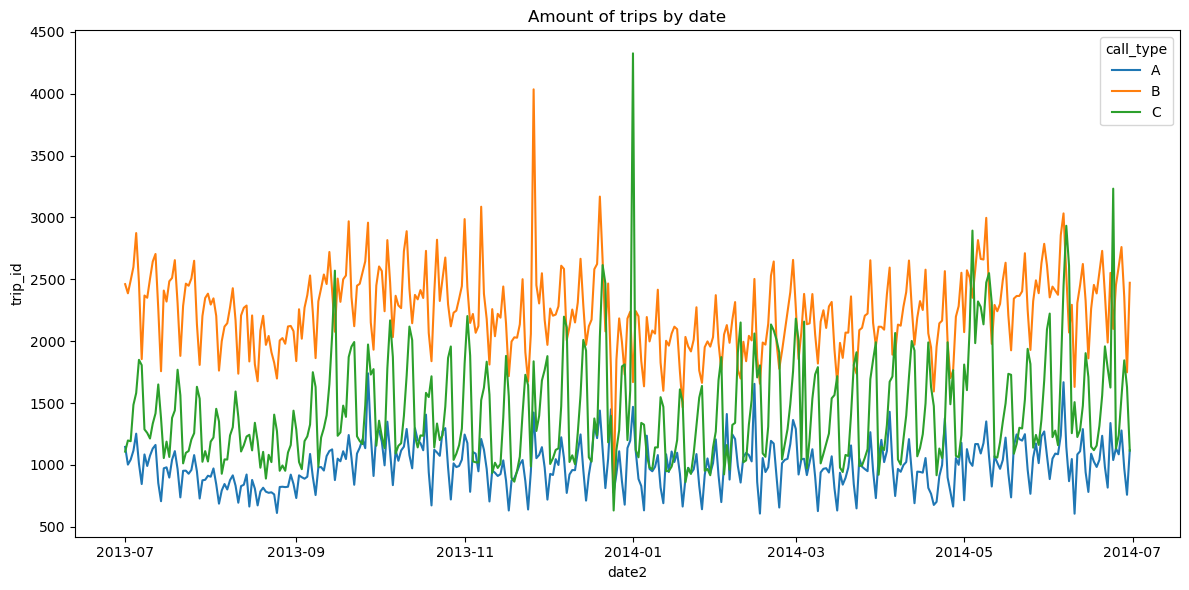

In [20]:
aux = df.groupby(['date2','call_type'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'call_type', ax = axes);
axes.set_title('Amount of trips by date')
plt.tight_layout();

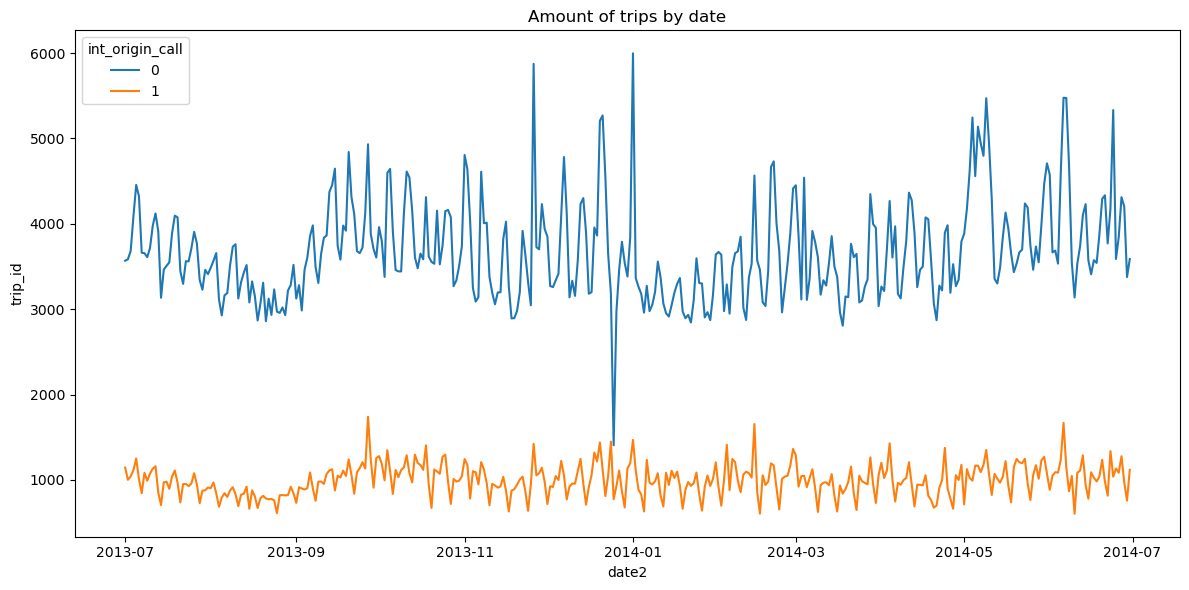

In [21]:
aux = df.groupby(['date2','int_origin_call'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'int_origin_call', ax = axes);
axes.set_title('Amount of trips by date')
plt.tight_layout();

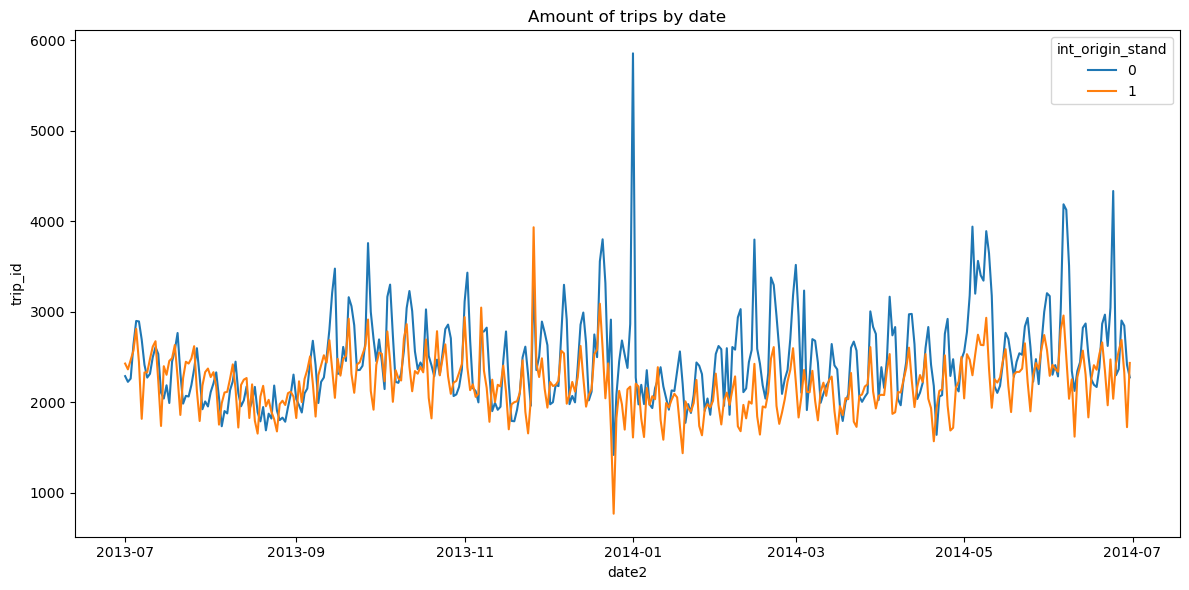

In [22]:
aux = df.groupby(['date2','int_origin_stand'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'int_origin_stand', ax = axes);
axes.set_title('Amount of trips by date')
plt.tight_layout();

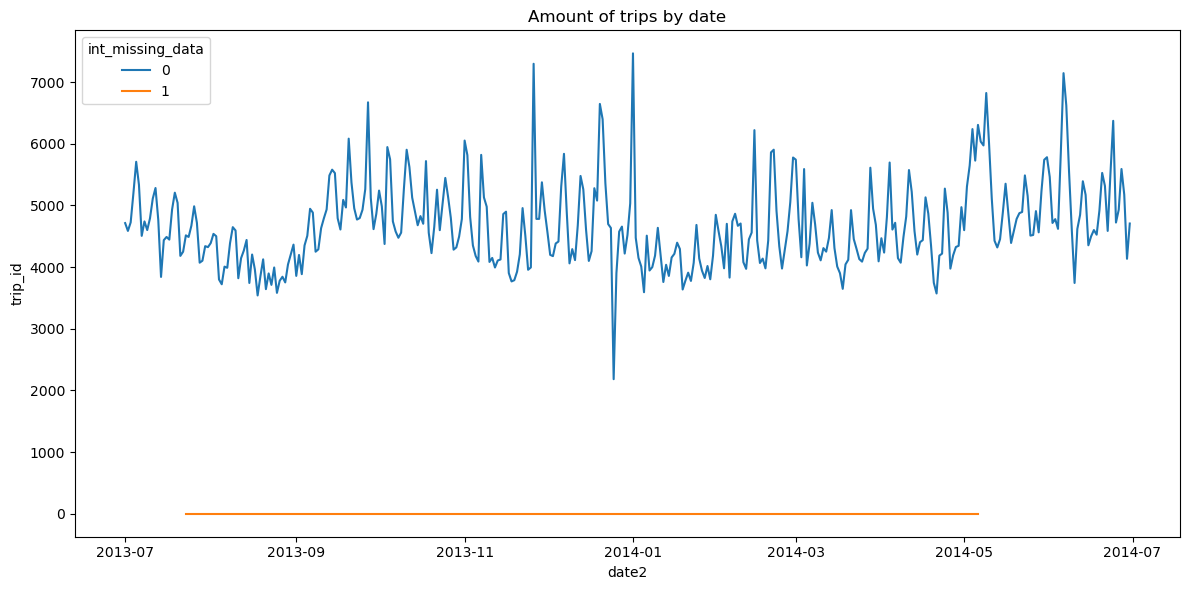

In [23]:
aux = df.groupby(['date2','int_missing_data'],as_index = False)['trip_id'].count()

fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data = aux, x = 'date2',y = 'trip_id',hue = 'int_missing_data', ax = axes);
axes.set_title('Amount of trips by date')
plt.tight_layout();

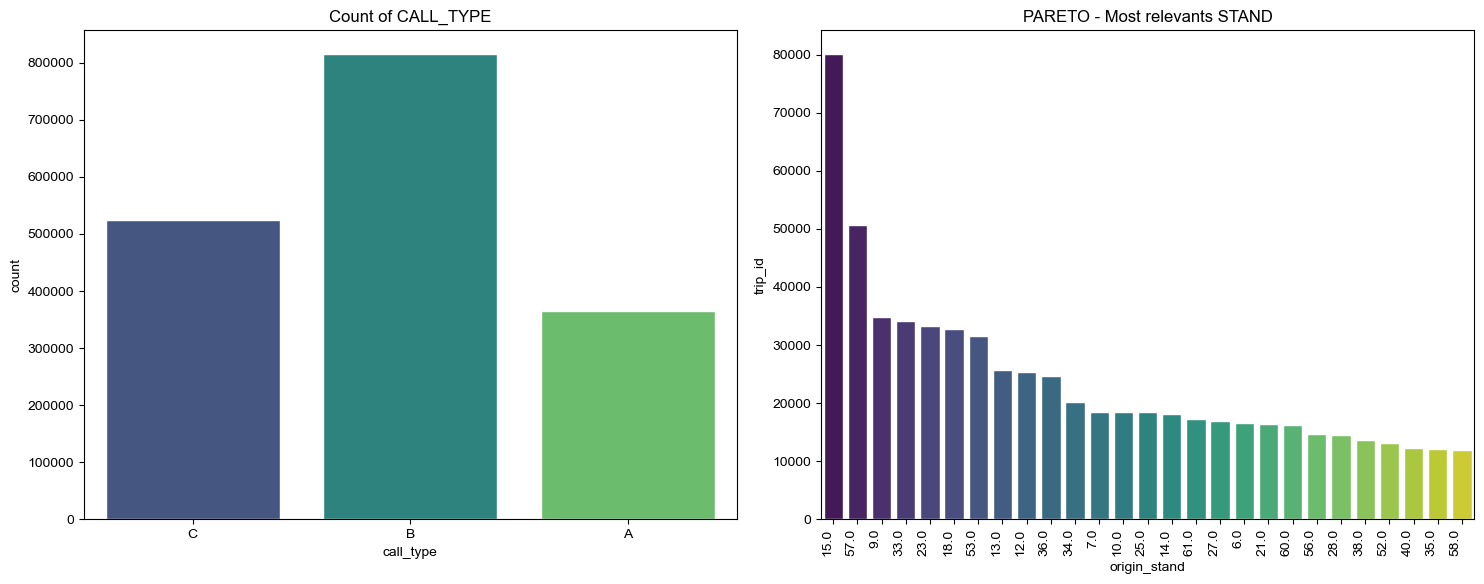

In [24]:
aux = df.groupby(['origin_stand'],as_index = False)['trip_id'].count()
aux = aux.sort_values(by = 'trip_id', ascending = False)
aux['pareto'] = aux['trip_id'].cumsum() / aux['trip_id'].sum()
aux = aux.loc[aux['pareto'] <= 0.8]


fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.set()
sns.countplot(data = df, x = 'call_type', palette='viridis',ax = axes[0]);
axes[0].set_title('Count of CALL_TYPE');

sns.barplot(data = aux, x = 'origin_stand',y = 'trip_id', palette='viridis',ax = axes[1], order = aux['origin_stand'].values);
axes[1].set_title('PARETO - Most relevants STAND');
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right')
plt.tight_layout();

We can see that most trip were occured started in a stand or randomly in street.

The stand 15 and 57 are the most relevants, with more than 50k of trips

In [25]:
df_folium = df.sample(n = 10000)
avg_lat = df_folium['lat_init'].mean()
avg_long = df_folium['long_init'].mean()
print(avg_lat,avg_long)

41.1570754605 -8.6172659712


In [26]:
mapa = folium.Map(location= [df_folium['lat_init'].mean(),df_folium['long_init'].mean()],zoom_start=10)

la_i = df_folium['lat_init'].values
lo_i = df_folium['long_init'].values
la_e = df_folium['lat_end'].values
lo_e = df_folium['long_end'].values
for i in range(len(la_i)):
    folium.CircleMarker(location=[la_i[i],lo_i[i]], radius=0.5, color="green").add_to(mapa)
for i in range(len(la_i)):
    folium.CircleMarker(location=[la_e[i],lo_e[i]], radius=0.5, color="red").add_to(mapa)


In [27]:
# mapa.save('../img/mapa_parcial.html')

# Data Preparation

In [28]:
# dummies for call_type
df = pd.get_dummies(df,columns=['call_type'],prefix='ct', drop_first=False)

In [29]:
df.to_parquet('../data/train_fe.parquet', index = False)

In [30]:
cols_modelo = ['int_origin_stand', 'int_origin_call', 'int_missing_data','ct_A', 'ct_B','ct_C','lat_init', 'long_init','lat_end', 'long_end']

In [31]:
X = df[cols_modelo].sample(frac = 0.5)

y = X[['lat_end', 'long_end']]

X = X.drop(['lat_end', 'long_end'], axis = 1)

In [32]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print('Train shape: ',X_train.shape)
print('Test shape: ',X_test.shape)

Train shape:  (639288, 8)
Test shape:  (213096, 8)


In [34]:
X_train.to_parquet('../data/X_train.parquet', index = False)
X_test.to_parquet('../data/X_test.parquet', index = False)
y_train.to_parquet('../data/y_train.parquet', index = False)
y_test.to_parquet('../data/y_test.parquet', index = False)

# Middle Reading

In [3]:
X_train = pd.read_parquet('../data/X_train.parquet')
X_test = pd.read_parquet('../data/X_test.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')
y_test = pd.read_parquet('../data/y_test.parquet')

# ML Modeling

In [15]:
# dr = MultiOutputRegressor(DummyRegressor(strategy='mean'))

# dr.fit(X_train, y_train)

# yhat_dr = dr.predict(X_test)

r2_dr = r2_score(y_test,yhat_dr)
rmse_dr = np.sqrt(mean_squared_error(y_test,yhat_dr))

print('R2 Score on test: ',r2_dr)
print('RMSE on test: ',rmse_dr)

R2 Score on test:  -2.722055185611083e-05
RMSE on test:  0.0365593172430847


In [22]:
# rfr = MultiOutputRegressor(RandomForestRegressor(n_estimators= 100, n_jobs=-1, random_state=42))

# rfr.fit(X_train, y_train)

# yhat_rfr = rfr.predict(X_test)

r2_rfr = r2_score(y_test,yhat_rfr)
rmse_rfr = np.sqrt(mean_squared_error(y_test,yhat_rfr))

print('R2 Score on test: ',r2_rfr)
print('RMSE on test: ',rmse_rfr)

R2 Score on test:  -0.07305458207851301
RMSE on test:  0.03784514884843693


In [17]:
# xgbr = MultiOutputRegressor(XGBRegressor(objective = 'reg:squarederror',n_estimators= 100, n_jobs=-1, random_state=42))

# xgbr.fit(X_train, y_train)

# yhat_xgbr = xgbr.predict(X_test)

r2_xgbr = r2_score(y_test,yhat_xgbr)
rmse_xgbr = np.sqrt(mean_squared_error(y_test,yhat_xgbr))

print('R2 Score on test: ',r2_xgbr)
print('RMSE on test: ',rmse_xgbr)

R2 Score on test:  0.0743449366319266
RMSE on test:  0.03515599880066873


In [18]:
# lr = MultiOutputRegressor(LinearRegression(n_jobs=-1))

# lr.fit(X_train, y_train)

# yhat_lr = lr.predict(X_test)

r2_lr = r2_score(y_test,yhat_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test,yhat_lr))

print('R2 Score on test: ',r2_lr)
print('RMSE on test: ',rmse_lr)

R2 Score on test:  -0.02004555486178261
RMSE on test:  0.037058247615717445


In [19]:
# lasso = MultiOutputRegressor(Lasso(alpha = 20, random_state=42))

# lasso.fit(X_train, y_train)

# yhat_lasso = lasso.predict(X_test)

r2_lasso = r2_score(y_test,yhat_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test,yhat_lasso))

print('R2 Score on test: ',r2_lasso)
print('RMSE on test: ',rmse_lasso)

R2 Score on test:  -2.722055185611083e-05
RMSE on test:  0.0365593172430847


In [20]:
# ridge = MultiOutputRegressor(Ridge(alpha = 20,max_iter=1000, random_state=42))

# ridge.fit(X_train, y_train)

# yhat_ridge = ridge.predict(X_test)

r2_ridge = r2_score(y_test,yhat_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test,yhat_ridge))

print('R2 Score on test: ',r2_ridge)
print('RMSE on test: ',rmse_ridge)

R2 Score on test:  -0.018500122563089916
RMSE on test:  0.03702419581043202


In [21]:
# ransac = MultiOutputRegressor(RANSACRegressor(random_state=42))

# ransac.fit(X_train, y_train)

# yhat_ransac = ransac.predict(X_test)

r2_ransac = r2_score(y_test,yhat_ransac)
rmse_ransac = np.sqrt(mean_squared_error(y_test,yhat_ransac))

print('R2 Score on test: ',r2_ransac)
print('RMSE on test: ',rmse_ransac)

R2 Score on test:  -11.671343712247264
RMSE on test:  0.1294599494453245


In [24]:
final_rmse = pd.DataFrame([
    ['Dummy',rmse_dr],
     ['RandomForest',rmse_rfr],
     ['XGB',rmse_xgbr],
     ['LinearReg',rmse_lr],
     ['Lasso',rmse_lasso],
     ['Ridge',rmse_ridge],
     ['RANSAC',rmse_ransac]
     ], columns=['Model','RMSE'])
final_rmse.sort_values('RMSE')

,Model,RMSE
2,XGB,0.035156
0,Dummy,0.036559
4,Lasso,0.036559
5,Ridge,0.037024
3,LinearReg,0.037058
1,RandomForest,0.037845
6,RANSAC,0.129460
